In [1]:
import logging
import sys
import ee
import pandas as pd
import numpy as np
import geopandas as gpd
from functools import reduce
from matplotlib import pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import *
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import brier_score_loss
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from scipy.spatial.distance import cdist
from esda.moran import Moran, Moran_Local
from libpysal.weights import DistanceBand, KNN
from shapely.geometry import Point
from shapely.geometry import mapping
from sklearn.metrics import precision_score, f1_score, log_loss
from sklearn.cluster import KMeans
from sklearn.utils import resample
from tqdm import tqdm
import os
import rasterio
from rasterio.mask import mask
from rasterio.warp import transform_geom
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
import warnings
import folium
from rasterio.plot import reshape_as_image
from branca.colormap import linear
from IPython.display import display

In [2]:
my_cloud_project = 'ee-shopvac18' # your GEE cloud project ID
ee.Authenticate(force = False) 
ee.Initialize(project=my_cloud_project) # your GEE cloud project

Enter verification code:  4/1AVMBsJi9RbRpx7Xzn7MMvWWfmQ3pnQhOI8V0SzPaEeE3IvvdnMCbt6NezPU



Successfully saved authorization token.


In [3]:
my_training_state = 'ID'
nas_name = 'EMF'
my_crs = "EPSG:5070"
my_scale = 100

In [4]:
my_predictors = [
    'Ca', 'pH', 'Nitrogen', 'DO', 'Phos', 
    'Precip_Winter',  'Precip_Summer', 'Flashiness',
    'LST_Summer', 'LST_Winter', 'NDVI', 'NDTI', 'NDBI', 'NDCI', 'NDSI',
    'Heat_Insolation', 'Topo_Diversity', 'gHM', 'Freeze_Up', 'Ice_Melt', 
    'Native_Fish_Richness', 'Inv_Algae', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusks',
    'Inv_Plants', 'Inv_Richness', 'Distance_River']

states = ee.FeatureCollection("TIGER/2018/States")
training_geo = states.filter(ee.Filter.eq("STUSPS", my_training_state)).geometry()

In [5]:
predictor_data = ee.Image("projects/ee-shopvac18/assets/" + my_training_state + "_predictors_" + nas_name ).select(my_predictors)
pos_data = ee.FeatureCollection('projects/ee-shopvac18/assets/' + my_training_state + "_" + nas_name + "_pos_data")
bg_data = ee.FeatureCollection('projects/ee-shopvac18/assets/' + my_training_state + "_" + nas_name + "_bg_data").filterBounds(training_geo)

In [6]:
# Reproject FeatureCollections (works as long as geometries exist)
def reproject_fc(fc):
    return fc.map(lambda f: f.setGeometry(f.geometry().transform('EPSG:5070', 0.01)))

def ee_fc_to_df(fc):
    """Convert an Earth Engine FeatureCollection to a clean Pandas DataFrame."""
    features = fc.getInfo()['features']
    rows = []
    for f in features:
        props = f['properties']
        coords = f['geometry']['coordinates']
        props['longitude'] = coords[0]
        props['latitude'] = coords[1]
        rows.append(props)

    df = pd.DataFrame(rows)

    # Drop columns that contain lists (like [1.1, 2.2] instead of a single value)
    df = df[[col for col in df.columns if not df[col].apply(lambda x: isinstance(x, list)).any()]]

    return df

def get_tss_metrics(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    specificity = 1 - fpr
    tss = tpr - fpr
    best_idx = np.argmax(tss)
    return {
        'threshold': thresholds[best_idx],
        'sensitivity': tpr[best_idx],
        'specificity': specificity[best_idx],
        'tss': tss[best_idx],
        'auc': roc_auc_score(y_true, y_probs)
    }
def compute_boyce(y_true, y_scores, n_bins=10):
    presence_scores = y_scores[y_true == 1]
    background_scores = y_scores[y_true == 0]
    if len(np.unique(presence_scores)) < 2:
        return np.nan
    bins = np.linspace(np.min(y_scores), np.max(y_scores), n_bins + 1)
    freq_presence = np.histogram(presence_scores, bins=bins)[0]
    freq_background = np.histogram(background_scores, bins=bins)[0]
    ratio = np.divide(freq_presence, freq_background, out=np.zeros_like(freq_presence, dtype=float), where=freq_background != 0)
    return np.corrcoef(np.arange(1, len(ratio) + 1), ratio)[0, 1]

def compute_ebi(y_true, y_scores):
    return abs(np.mean(y_scores[y_true == 1]) - np.mean(y_scores[y_true == 0]))

def compute_moran(residuals, coords, permutations=999):
    from libpysal.weights import DistanceBand
    from esda.moran import Moran
    import numpy as np

    try:
        w = DistanceBand(coords, threshold=100000, binary=True, silence_warnings=True)
        moran = Moran(residuals, w, permutations=permutations)

        # Handle cases where seI_sim is 0
        if moran.seI_sim == 0 or np.isinf(moran.z_sim):
            return np.nan, np.nan
        else:
            return moran.I, moran.p_sim
    except Exception as e:
        print(f"Warning: Moran's I computation failed: {e}")
        return np.nan, np.nan


def compute_local_moran(residuals, coords, k_neighbors=10):
    """Compute median Local Moran's I value and mean p-value across all observations."""
    gdf = gpd.GeoDataFrame({'residuals': residuals}, geometry=[Point(x, y) for x, y in coords])
    gdf = gdf[gdf.geometry.notnull() & gdf['residuals'].notnull()]

    if len(gdf) < 4:
        raise ValueError("Too few valid points for Local Moran's I")

    w = KNN.from_dataframe(gdf, k=min(k_neighbors, len(gdf)-1))
    lisa = Moran_Local(gdf['residuals'], w)

    median_I = np.median(lisa.Is)
    mean_p = np.mean(lisa.p_sim)

    return median_I, mean_p

def get_f1_metrics(y_true, y_probs):
    # Generate precision, recall, thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    
    # Manually compute F1 at each threshold (note: last threshold is not used)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Avoid NaN or inf
    f1_scores = np.nan_to_num(f1_scores, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Get the threshold that maximizes F1
    best_idx = np.argmax(f1_scores[:-1])  # exclude last, which doesn't have a threshold

    return {
        'threshold': thresholds[best_idx],
        'precision': precision[best_idx],
        'recall': recall[best_idx],
        'f1': f1_scores[best_idx],
        'auc': roc_auc_score(y_true, y_probs)  # optional but often useful
    }

def compute_sample_weights(y):
    """Compute inverse frequency-based sample weights for binary classification."""
    y_array = np.asarray(y).astype(int)
    class_counts = np.bincount(y_array)
    total = len(y_array)
    class_weights = {cls: total / (2 * count) for cls, count in enumerate(class_counts) if count > 0}
    return np.array([class_weights[label] for label in y_array])

def format_results(spatial_scale, replicate_idx, model_name, metrics, importance_dict, train_pos, train_neg, test_pos, test_neg, prevalence_train):
    row = {
        'spatial_scale': spatial_scale,
        'replicate': replicate_idx + 1,
        'model': model_name,
        'AUC': metrics['auc'],
        'threshold': metrics['threshold'],
        'TSS': metrics['tss'],
        'sensitivity': metrics['sensitivity'],
        'specificity': metrics['specificity'],
        'precision': metrics['precision'],
        'f1_score': metrics['f1_score'],
        'log_loss': metrics['log_loss'],
        'prob_mean': metrics['prob_mean'],
        'prob_std': metrics['prob_std'],
        'prevalence_train': metrics['prevalence_train'],
        'prevalence_test': metrics['prevalence_test'],
        'Boyce': metrics['boyce'],
        'EBI': metrics['ebi'],
        'Train_Pos': train_pos,
        'Train_Neg': train_neg,
        'Test_Pos': test_pos,
        'Test_Neg': test_neg,
        'geo_novelty_mean': metrics['geo_novelty_mean'],
        'geo_novelty_std': metrics['geo_novelty_std'],
        'TSS_Novel': metrics['tss_novel'],
        'novelty_mean_incorrect': metrics['novelty_mean_incorrect'],
        'novelty_mean_correct': metrics['novelty_mean_correct'],
        'brier': metrics['brier'],
        'residual_mean': metrics['residual_mean'],
        'residual_std': metrics['residual_std'],
        'prediction_rate': metrics['prediction_rate'],
        'moran_i': metrics['moran_i'],
        'moran_p': metrics['moran_p'],
    }
    for feat, val in importance_dict.items():
        row[f'FI_{feat}'] = val
    return row

class PacmanTQDM(tqdm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    @staticmethod
    def format_meter(n, total, elapsed, **kwargs):
        pacman = 'C' if n % 2 == 0 else 'ᗧ'  # Chomping animation
        max_width = 20  # Total bar length (dots)
        bar_length = min(max_width, total if total else max_width)

        # Calculate how far Pac-Man has gone (in characters)
        position = int((n / total) * bar_length) if total else 0

        # Bar: eaten = ' ', remaining = '.', Pac-Man at current position
        eaten = ' ' * position
        remaining = '.' * (bar_length - position - 1)  # -1 for Pac-Man itself
        bar = eaten + pacman + remaining

        return f'{bar} {n}/{total} replicates'

    def __str__(self):
        return self.format_meter(self.n, self.total, self.format_dict.get('elapsed', 0))

def dataset_tester(pred_data, pos_data, bg_data, split_value, seed, scale=100):
    # Split presence data
    X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(
        pos_data.drop(columns=['Present']),
        pos_data['Present'],
        test_size=1 - split_value,
        train_size=split_value,
        random_state=seed
    )

    # Split background data (retain full set)
    X_bg_train_full, X_bg_test_full, y_bg_train_full, y_bg_test_full = train_test_split(
        bg_data.drop(columns=['Present']),
        bg_data['Present'],
        test_size=1 - split_value,
        train_size=split_value,
        random_state=seed
    )

    # Subsample background test data to match presence test size (with replacement fallback)
    replace_flag = len(X_bg_test_full) < len(y_pos_test)
    X_bg_test = X_bg_test_full.sample(n=len(y_pos_test), random_state=seed, replace=replace_flag)
    y_bg_test = y_bg_test_full.loc[X_bg_test.index]

    # Training data uses full available background
    X_bg_train = X_bg_train_full
    y_bg_train = y_bg_train_full

    # Combine training and test sets
    X_train = pd.concat([X_pos_train, X_bg_train])
    y_train = pd.concat([y_pos_train, y_bg_train])
    X_test = pd.concat([X_pos_test, X_bg_test])
    y_test = pd.concat([y_pos_test, y_bg_test])

    # Save coordinates from X_test before dropping them
    if 'longitude' in X_test.columns and 'latitude' in X_test.columns:
        coords_test = list(zip(X_test['longitude'], X_test['latitude']))
    else:
        coords_test = [(None, None)] * len(X_test)

    # Drop coordinates for modeling
    X_train = X_train.drop(columns=['longitude', 'latitude'], errors='ignore')
    X_test = X_test.drop(columns=['longitude', 'latitude'], errors='ignore')

    # Track feature names
    feature_names = X_train.columns.tolist()

    # Normalize features
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # PCA for novelty distance
    pca = PCA(n_components=3).fit(X_train_scaled)
    train_pca = pca.transform(X_train_scaled)
    test_pca = pca.transform(X_test_scaled)
    novelty_dists = np.min(cdist(test_pca, train_pca), axis=1)
    novelty_mean = novelty_dists.mean()
    novelty_std = novelty_dists.std()

    # Count train/test positives and negatives
    train_pos_count = (y_train == 1).sum()
    train_neg_count = (y_train == 0).sum()
    test_pos_count = (y_test == 1).sum()
    test_neg_count = (y_test == 0).sum()

    return (
        X_train_scaled, y_train,
        X_test_scaled, y_test,
        feature_names,
        int(train_pos_count), int(train_neg_count),
        int(test_pos_count), int(test_neg_count),
        novelty_mean, novelty_std,
        novelty_dists,
        coords_test
    )

    
def fit_and_evaluate_model(model, X_train, y_train, X_test, y_test, feature_names, novelty_dists, coords_test, prevalence_train, use_permutation=True, sample_weight=None):
    y_train = np.asarray(y_train).astype(int)
    y_test = np.asarray(y_test).astype(int)

    model_name = type(model).__name__.lower()

    # Safe application of sample_weight
    try:
        if model_name in ['gradientboostingclassifier', 'histgradientboostingclassifier']:
            model.fit(X_train, y_train, sample_weight=sample_weight)
        elif model_name == 'mlpclassifier':
            try:
                model.fit(X_train, y_train, sample_weight=sample_weight)
            except TypeError:
                print("Warning: MLPClassifier does not support sample_weight in your version. Fitting without weights.")
                model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train)
    except Exception as e:
        print(f"Model fitting failed: {e}")
        return None, dict(zip(feature_names, [np.nan] * len(feature_names)))

    # Probability prediction
    try:
        probs = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        probs = model.decision_function(X_test)
        probs = (probs - probs.min()) / (probs.max() - probs.min())

    # Main metrics
    tss_metrics = get_tss_metrics(y_test, probs)
    f1_metrics = get_f1_metrics(y_test, probs)
    novel_mask = novelty_dists >= 0.05
    tss_novel = get_tss_metrics(y_test[novel_mask], probs[novel_mask])['tss'] if novel_mask.sum() >= 2 else np.nan
    boyce = compute_boyce(y_test, probs)
    ebi = compute_ebi(y_test, probs)
    brier = brier_score_loss(y_test, probs)
    residuals = y_test - probs

    # Binary prediction
    y_pred = (probs >= tss_metrics['threshold']).astype(int)
    is_incorrect = y_pred != y_test

    test_results = pd.DataFrame({
        'true': y_test,
        'pred': y_pred,
        'prob': probs,
        'novelty': novelty_dists,
        'incorrect': is_incorrect
    })

    novelty_mean = novelty_dists.mean()
    novelty_std = novelty_dists.std()
    novelty_mean_incorrect = test_results[test_results['incorrect']]['novelty'].mean()
    novelty_mean_correct = test_results[~test_results['incorrect']]['novelty'].mean()

    precision = precision_score(y_test, y_pred, zero_division=0)
    logloss = log_loss(y_test, probs)
    prob_mean = probs.mean()
    prob_std = probs.std()
    prevalence_test = y_test.mean()

    metrics = {
        'threshold': tss_metrics['threshold'],
        'sensitivity': tss_metrics['sensitivity'],
        'specificity': tss_metrics['specificity'],
        'tss': tss_metrics['tss'],
        'auc': tss_metrics['auc'],
        'boyce': boyce,
        'ebi': ebi,
        'brier': brier,
        'residual_mean': residuals.mean(),
        'residual_std': residuals.std(),
        'prediction_rate': (probs >= tss_metrics['threshold']).mean(),
        'geo_novelty_mean': novelty_mean,
        'geo_novelty_std': novelty_std,
        'tss_novel': tss_novel,
        'novelty_mean_incorrect': novelty_mean_incorrect,
        'novelty_mean_correct': novelty_mean_correct,
        'precision': precision,
        'f1_score': f1_metrics['f1'],
        'log_loss': logloss,
        'prob_mean': prob_mean,
        'prob_std': prob_std,
        'prevalence_train': prevalence_train,
        'prevalence_test': prevalence_test
    }

    # Moran's I or Local Moran's I depending on sample size
    try:
        if len(residuals) >= 100:
            moran_i, moran_p = compute_moran(residuals, coords_test)
        else:
            moran_i, moran_p = compute_local_moran(residuals, coords_test)
    except Exception as e:
        print(f"Warning: Moran's I failed with error: {e}")
        moran_i, moran_p = np.nan, np.nan
    
    metrics['moran_i'] = moran_i
    metrics['moran_p'] = moran_p

    # Feature importances
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_') and hasattr(model.coef_, 'flatten'):
            importances = model.coef_.flatten()
        elif use_permutation:
            from sklearn.inspection import permutation_importance
            perm_result = permutation_importance(
                model, X_test, y_test, n_repeats=30, random_state=42,
                n_jobs=1,
                sample_weight=sample_weight if model_name in ['gradientboostingclassifier'] else None
            )
            importances = perm_result.importances_mean
        else:
            importances = np.full(len(feature_names), np.nan)
    except Exception as e:
        print(f"Feature importance error: {e}")
        importances = np.full(len(feature_names), np.nan)

    importance_dict = dict(zip(feature_names, importances))
    return metrics, importance_dict


def run_model_replicates(pred_data, pos_data, bg_data, spatial_scale='state', n_replicates=3, seed_start=12345, scale=100):
    base_model_defs = [
        ('MaxEnt', LogisticRegression(max_iter=10000, class_weight='balanced')),
        ('RF', RandomForestClassifier(n_estimators=1000, class_weight='balanced')),
        ('BRT', GradientBoostingClassifier(n_estimators=1000)),
        ('DT', DecisionTreeClassifier(class_weight='balanced')),
        ('MLP', MLPClassifier(max_iter=10000))
    ]

    results = []
    np.random.seed(seed_start)
    seeds = np.random.randint(0, 1_000_000, size=n_replicates) 

    for run_i in PacmanTQDM(range(n_replicates), desc=f"{spatial_scale.title()}"):
        split_value = 0.75    

        X_train, y_train, X_test, y_test, features, train_pos, train_neg, test_pos, test_neg, novelty_mean, novelty_std, novelty_dists, coords_test = dataset_tester(
            pred_data, pos_data, bg_data, split_value, seeds[run_i], scale
        )

        sample_weights = compute_sample_weights(y_train)
        model_metrics = {} 
        model_importances = {}

        for model_name, model in base_model_defs:
            prevalence_train = y_train.mean()

            metrics, importance = fit_and_evaluate_model(
                model, X_train, y_train, X_test, y_test,
                features, novelty_dists, coords_test, prevalence_train,
                sample_weight=sample_weights if model_name in ['BRT', 'MLP'] else None
            )

            model_metrics[model_name] = metrics
            model_importances[model_name] = importance

            row = format_results(
                spatial_scale, run_i, model_name,
                metrics, importance,
                train_pos, train_neg, test_pos, test_neg,
                prevalence_train
            )
            results.append(row)

        auc_thresh = 0.75
        tss_thresh = 0.65

        selected_models = [
            (name, model) for name, model in base_model_defs
            if model_metrics[name]['auc'] >= auc_thresh and model_metrics[name]['tss'] >= tss_thresh
        ]

        if len(selected_models) > 1:
            vc = VotingClassifier(selected_models, voting='soft')
            prevalence_train = y_train.mean()
            metrics, importance = fit_and_evaluate_model(
                vc,
                X_train, y_train, X_test, y_test,
                feature_names=features,
                novelty_dists=novelty_dists,
                coords_test=coords_test,
                prevalence_train=prevalence_train,
                use_permutation=True,
                sample_weight=sample_weights
            )

            row = format_results(
                spatial_scale, run_i, 'VC',
                metrics, importance,
                train_pos, train_neg, test_pos, test_neg,
                prevalence_train
            )
            results.append(row)

        if len(selected_models) > 1:
            stack = StackingClassifier(estimators=selected_models, final_estimator=RandomForestClassifier())
            metrics, importance = fit_and_evaluate_model(
                stack, X_train, y_train, X_test, y_test,
                features, novelty_dists, coords_test, prevalence_train,
                use_permutation=True,
                sample_weight=sample_weights
            )
            row = format_results(
                spatial_scale, run_i, 'Stack',
                metrics, importance,
                train_pos, train_neg, test_pos, test_neg,
                prevalence_train
            )
            results.append(row)

    return pd.DataFrame(results)

def score_models(
    metrics_df,
    group_title="Model Performance Summary",
    discrim_weights={"TSS": 0.5, "F1": 0.3, "AUC": 0.2},
    calib_weights={"Boyce": 0.5, "LogLoss": 0.3, "Brier": 0.2},
    calib_weights_dt={"Boyce": 0.5, "Brier": 0.5},
    composite_weights={"Discrim": 0.7, "Calib": 0.2, "Spatial": 0.1},
    novelty_bonus_weight=0.05,
    novelty_bonus_threshold=0.05,
    top_only=False
):
    def benchmark_normalize_quantile(x, q_min=0.1, q_max=0.9):
        if x.isna().all():
            return np.full(len(x), np.nan)
        min_val = x.quantile(q_min)
        max_val = x.quantile(q_max)
        if min_val == max_val:
            return np.full(len(x), 0.5)
        scaled = (x - min_val) / (max_val - min_val)
        return scaled.clip(0, 1)

    df = metrics_df.copy()
    df["log_loss"] = np.where(df["model"] == "DT", np.nan, df["log_loss"])

    # Normalize scores
    df["TSS_scaled"] = benchmark_normalize_quantile(df["TSS"])
    df["AUC_scaled"] = benchmark_normalize_quantile(df["AUC"])
    df["f1_scaled"] = benchmark_normalize_quantile(df["f1_score"])
    df["Boyce_scaled"] = benchmark_normalize_quantile(df["Boyce"])
    df["logloss_scaled"] = 1 - benchmark_normalize_quantile(df["log_loss"])
    df["brier_scaled"] = 1 - benchmark_normalize_quantile(df["brier"])
    df["TSS_novel_scaled"] = benchmark_normalize_quantile(df["TSS_Novel"])
    df["novelty_correct_scaled"] = benchmark_normalize_quantile(df["novelty_mean_correct"])
    df["novelty_incorrect_scaled"] = 1 - benchmark_normalize_quantile(df["novelty_mean_incorrect"])
    df["residual_mean_scaled"] = 1 - benchmark_normalize_quantile(df["residual_mean"].abs())
    df["residual_std_scaled"] = 1 - benchmark_normalize_quantile(df["residual_std"])
    df["moran_i_scaled"] = 1 - benchmark_normalize_quantile(df["moran_i"].abs())

    # Discrimination score with weights and missing-safe handling
    def compute_discrim_score(row):
        score = 0
        total_weight = 0
        for metric, weight in discrim_weights.items():
            val = row.get(f"{metric.lower()}_scaled", np.nan)
            if not pd.isna(val):
                score += weight * val
                total_weight += weight
        return score / total_weight if total_weight > 0 else np.nan

    df["discrim_score"] = df.apply(compute_discrim_score, axis=1)

    def compute_calib_score(row):
            # Define dynamic weights per row based on what's available
            metrics = []
            weights = []
            
            if row["model"] == "MaxEnt":
                if not pd.isna(row["Boyce_scaled"]):
                    return calib_weights["Boyce"] * row["Boyce_scaled"]
                else:
                    return np.nan
    
            elif row["model"] == "DT":
                if not pd.isna(row["Boyce_scaled"]):
                    metrics.append(row["Boyce_scaled"])
                    weights.append(calib_weights_dt["Boyce"])
                if not pd.isna(row["brier_scaled"]):
                    metrics.append(row["brier_scaled"])
                    weights.append(calib_weights_dt["Brier"])
            else:
                if not pd.isna(row["Boyce_scaled"]):
                    metrics.append(row["Boyce_scaled"])
                    weights.append(calib_weights["Boyce"])
                if not pd.isna(row["logloss_scaled"]):
                    metrics.append(row["logloss_scaled"])
                    weights.append(calib_weights["LogLoss"])
                if not pd.isna(row["brier_scaled"]):
                    metrics.append(row["brier_scaled"])
                    weights.append(calib_weights["Brier"])
    
            if len(metrics) == 0:
                return np.nan
            else:
                weights = np.array(weights)
                weights = weights / weights.sum()  # re-normalize to sum to 1
                return np.sum(np.array(metrics) * weights)

    df["calib_score"] = df.apply(compute_calib_score, axis=1)

    # Spatial score with equal weights (can be extended to weighted if needed)
    spatial_metrics = ["residual_mean_scaled", "residual_std_scaled", "moran_i_scaled"]
    def compute_spatial_score(row):
        values = [row[m] for m in spatial_metrics if not pd.isna(row[m])]
        return np.mean(values) if values else np.nan

    df["spatial_score"] = df.apply(compute_spatial_score, axis=1)

    # Novelty scores
    df["novelty_score_raw"] = df["TSS_novel_scaled"]
    df["novelty_score"] = np.minimum(df["novelty_score_raw"] * novelty_bonus_weight, novelty_bonus_weight)
    df["novelty_bonus_flag"] = df["geo_novelty_mean"] >= novelty_bonus_threshold
    df["novelty_bonus_applied"] = np.where(df["novelty_bonus_flag"], df["novelty_score"], 0.0)

    # Weighted component contributions
    df["weighted_discrim"] = composite_weights["Discrim"] * df["discrim_score"]
    df["weighted_calib"] = composite_weights["Calib"] * df["calib_score"]
    df["weighted_spatial"] = composite_weights["Spatial"] * df["spatial_score"]

    df["core_perf_score"] = df["weighted_discrim"] + df["weighted_calib"] + df["weighted_spatial"]

    df["final_perf_score"] = (df["core_perf_score"] + df["novelty_bonus_applied"]).clip(upper=1)

    # Composite summary
    summary_cols = {
        "final_perf_score": "mean_final_score",
        "weighted_discrim": "mean_weighted_discrim",
        "weighted_calib": "mean_weighted_calib",
        "weighted_spatial": "mean_weighted_spatial",
        "novelty_score": "mean_weighted_novelty",
        "discrim_score": "mean_discrim",
        "calib_score": "mean_calib",
        "spatial_score": "mean_spatial",
        "novelty_score_raw": "mean_novelty_raw"}

    group_cols = ["model"]
    composite_df = df.groupby(group_cols).agg(
        {col: "mean" for col in summary_cols}
    ).rename(columns=summary_cols).reset_index()
    composite_df["n"] = df.groupby(group_cols).size().values

    if top_only:
        composite_df = (
            composite_df.sort_values("mean_final_score", ascending=False)
            .groupby(["model"])
            .head(1)
            .reset_index(drop=True)
        )

    return {
        "composite_df": composite_df
    }

In [7]:
pos_fc = predictor_data.reduceRegions(
        collection=pos_data,
        reducer=ee.Reducer.mean(),
        crs= my_crs,
        scale= 100
    )
pos_data_df = ee_fc_to_df(pos_fc).dropna().astype(float)

In [8]:
bg_fc = predictor_data.reduceRegions(
        collection=bg_data,
        reducer=ee.Reducer.mean(),
        crs= my_crs,
        scale=100
    )
bg_data_df = ee_fc_to_df(bg_fc).dropna().astype(float)

"""
⚠️  Note on Warnings:
Some warnings may appear during model evaluation, such as:
- 'Weights matrix not fully connected': common in spatial metrics with sparse or clustered data.
- 'Divide by zero' or 'invalid value': may occur in metrics like Boyce index or Log Loss for small sample sizes.

These warnings do not indicate pipeline failure and can be safely ignored unless followed by an error.
"""

In [11]:
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="divide by zero encountered in divide")
model_test_df = run_model_replicates(
        pred_data=predictor_data,
        pos_data=pos_data_df,
        bg_data=bg_data_df,
        spatial_scale='State',
        n_replicates=3,
        seed_start=1,
        scale=100  # your Earth Engine scale parameter
)  

   ᗧ 3/3 replicates


In [12]:
#Identify top model
model_result = score_models(model_test_df)
composite_df = model_result["composite_df"]

In [13]:
composite_df

,model,mean_final_score,mean_weighted_discrim,mean_weighted_calib,mean_weighted_spatial,mean_weighted_novelty,mean_discrim,mean_calib,mean_spatial,mean_novelty_raw,n
0,BRT,0.896315,0.700000,0.085418,0.075874,0.050000,1.000000,0.427088,0.758744,1.000000,3
1,DT,0.243260,0.119658,0.052180,0.060507,0.010915,0.170940,0.260898,0.605074,0.218301,3
2,MLP,0.461108,0.358537,0.047578,0.027493,0.027500,0.512195,0.237892,0.274926,0.550000,3
3,MaxEnt,0.364437,0.245000,0.055950,0.044320,0.019167,0.350000,0.279751,0.443197,0.383333,3
4,RF,0.949918,0.700000,0.151957,0.047961,0.050000,1.000000,0.759787,0.479605,1.000000,3
5,Stack,1.000000,0.700000,0.196507,0.086374,0.050000,1.000000,0.982535,0.863742,1.000000,3
6,VC,0.965616,0.700000,0.153190,0.062426,0.050000,1.000000,0.765950,0.624265,1.000000,3


In [14]:
# Define base models
base_model_defs = [
    ('MaxEnt', LogisticRegression(max_iter=10000, class_weight='balanced')),
    ('RF', RandomForestClassifier(n_estimators=1000, class_weight='balanced')),
    ('BRT', GradientBoostingClassifier(n_estimators=1000)),
    ('DT', DecisionTreeClassifier(class_weight='balanced')),
    ('MLP', make_pipeline(StandardScaler(), MLPClassifier(max_iter=10000)))  # MLP needs scaling
]

# Dict for individual models
model_dict = {name: model for name, model in base_model_defs}
selected_model_names = (
    model_test_df[
        (model_test_df['TSS'] >= 0.65) & (model_test_df['AUC'] >= 0.75)
    ]['model']
    .unique()
    .tolist()
)
filtered_estimators = [
    (name, model) for name, model in base_model_defs if name in selected_model_names
]
# Define ensemble models
if len(filtered_estimators) > 1:
    voting_clf = VotingClassifier(estimators=filtered_estimators, voting='soft')
    stacking_clf = StackingClassifier(
        estimators=filtered_estimators,
        final_estimator=RandomForestClassifier(n_estimators=1000)
    )
else:
    voting_clf, stacking_clf = None, None  # Or handle as needed

# model_dict["VC"] = voting_clf
# model_dict["Stack"] = stacking_clf

In [15]:
top_model_name = composite_df.sort_values("mean_final_score", ascending=False).iloc[0]["model"]
print("Top model:", top_model_name)

Top model: Stack


In [16]:
# 1. Filter for replicates from the top model
top_model_rows = model_test_df[model_test_df["model"] == top_model_name]

# 2. Get feature importance columns
fi_cols = [col for col in top_model_rows.columns if col.startswith("FI_")]

# 3. Calculate mean of absolute values
fi_abs = top_model_rows[fi_cols].abs()
fi_means = fi_abs.mean().reset_index()
fi_means.columns = ["Feature", "Mean_Abs_Importance"]

# 4. Normalize to [0, 1]
min_val = fi_means["Mean_Abs_Importance"].min()
max_val = fi_means["Mean_Abs_Importance"].max()
fi_means["Normalized_Importance"] = (fi_means["Mean_Abs_Importance"] - min_val) / (max_val - min_val)

# 5. Clean up feature names (remove "FI_")
fi_means["Feature"] = fi_means["Feature"].str.replace("^FI_", "", regex=True)

# 6. Sort for plotting
fi_means = fi_means.sort_values("Normalized_Importance", ascending=True)


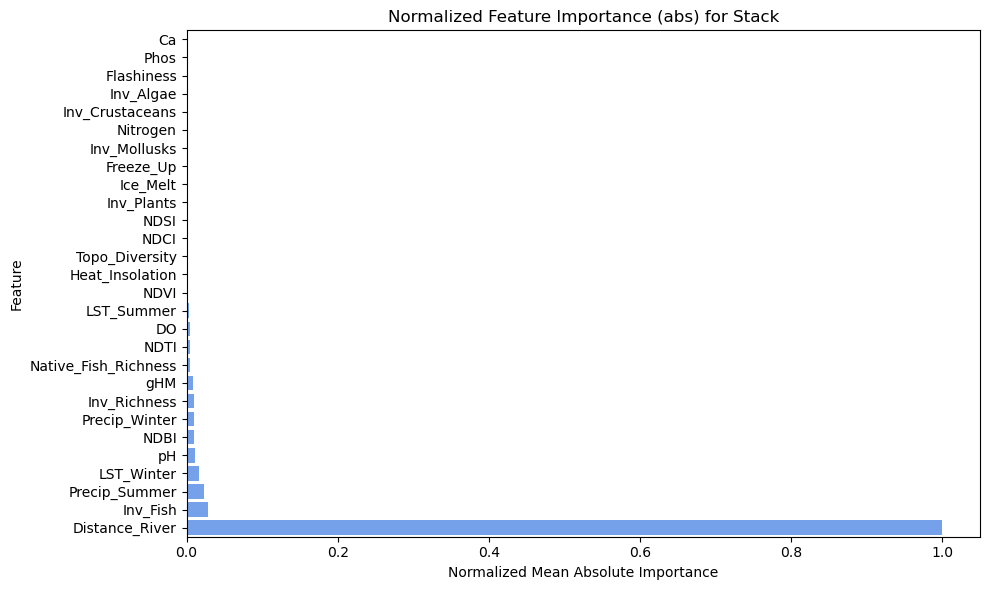

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=fi_means,
    x="Normalized_Importance",
    y="Feature",
    color="#619CFF"
)
plt.title(f"Normalized Feature Importance (abs) for {top_model_name}")
plt.xlabel("Normalized Mean Absolute Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [18]:
# Combine positive and background data
full_df = pd.concat([pos_data_df, bg_data_df], ignore_index=True).drop(columns=['longitude', 'latitude'], errors='ignore')
X = full_df.drop(columns=["Present"])
y = full_df["Present"]
# Capture trained features
trained_features = X.columns.tolist()
# Compute sample weights
sample_weights = compute_sample_weights(y)

# === Scaling ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Filter base estimators from base_model_defs
filtered_estimators = [
    (name, model) for name, model in base_model_defs if name in selected_model_names
]

# Rebuild final model if ensemble
if top_model_name == "VC":
    final_model = VotingClassifier(estimators=filtered_estimators, voting="soft")
elif top_model_name == "Stack":
    final_model = StackingClassifier(
        estimators=filtered_estimators,
        final_estimator=RandomForestClassifier(n_estimators=1000)
    )
else:
    final_model = model_dict[top_model_name]

# Fit the model with or without sample weights
needs_sample_weight = top_model_name in ["BRT", "MLP"]

if needs_sample_weight:
    final_model.fit(X_scaled, y, sample_weight=sample_weights)
else:
    final_model.fit(X_scaled, y)


In [24]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import folium
from rasterio.plot import reshape_as_image
from branca.colormap import LinearColormap
from folium.raster_layers import ImageOverlay
from folium.plugins import Fullscreen

def predict_raster(
    model,
    trained_features,
    raster_path,
    output_dir="static",
    normalize=False,
    scaler=None,
    mask_band=None  # optional mask band (e.g., 'Native_Fish_Richness')
):
    def get_band_names(raster_path):
        with rasterio.open(raster_path) as src:
            descriptions = src.descriptions
        return [b if b is not None else f"band_{i+1}" for i, b in enumerate(descriptions)]

    output_tif = os.path.join(output_dir, "Predicted_Output.tif")

    all_band_names = get_band_names(raster_path)
    band_indices = [all_band_names.index(b) for b in trained_features]

    mask_idx = all_band_names.index(mask_band) if mask_band in all_band_names else None if mask_band is None else ValueError(f"Mask band '{mask_band}' not found")

    with rasterio.open(raster_path) as src:
        meta = src.meta.copy()
        raster_data = src.read(indexes=[i + 1 for i in band_indices])
        transform = src.transform
        bounds = src.bounds
        crs = src.crs

        if mask_idx is not None:
            mask_data = src.read(mask_idx + 1)

    n_rows, n_cols = raster_data.shape[1:]
    img_2d = raster_data.reshape(len(trained_features), -1).T

    if scaler is not None:
        img_2d = scaler.transform(img_2d)

    valid_mask = ~np.isnan(img_2d).any(axis=1)

    if mask_idx is not None:
        flat_mask = mask_data.flatten()
        valid_mask &= ~np.isnan(flat_mask) & (flat_mask > 0)

    preds = np.full(img_2d.shape[0], np.nan)
    preds[valid_mask] = model.predict_proba(img_2d[valid_mask])[:, 1]

    if normalize:
        valid_preds = preds[valid_mask]
        pmin, pmax = np.nanmin(valid_preds), np.nanmax(valid_preds)
        if not np.isclose(pmin, pmax):
            preds[valid_mask] = (valid_preds - pmin) / (pmax - pmin)
        else:
            preds[valid_mask] = 0.0

    preds_image = preds.reshape(n_rows, n_cols)

    # Save GeoTIFF
    os.makedirs(output_dir, exist_ok=True)
    meta.update(dtype=rasterio.float32, count=1, nodata=np.nan)
    with rasterio.open(output_tif, "w", **meta) as dst:
        dst.write(preds_image.astype(np.float32), 1)

    # Normalize for display (0-1 range)
    img = preds_image.copy()
    img = np.clip(img, 0, 1)

    # Create colormap and map
    colormap = LinearColormap(
        colors=["blue", "cyan", "yellow", "red"],
        vmin=0, vmax=1,
        caption="Predicted Probability"
    )

    # Convert bounds to lat/lon if needed
    from rasterio.warp import transform_bounds
    bounds_wgs84 = transform_bounds(crs, "EPSG:4326", *bounds)

    # Convert to RGB image for folium overlay
    rgba = plt.cm.get_cmap("RdYlBu_r")(img)  # blue to red
    rgb_img = (rgba[:, :, :3] * 255).astype(np.uint8)

    # Save RGB image temporarily
    overlay_path = os.path.join(output_dir, "Predicted_Overlay.png")
    plt.imsave(overlay_path, rgb_img)

    # Create folium map
    m = folium.Map(
        location=[(bounds_wgs84[1] + bounds_wgs84[3]) / 2,
                  (bounds_wgs84[0] + bounds_wgs84[2]) / 2],
        zoom_start=7,
        tiles="cartodbpositron"
    )

    ImageOverlay(
        name="Prediction",
        image=overlay_path,
        bounds=[[bounds_wgs84[1], bounds_wgs84[0]], [bounds_wgs84[3], bounds_wgs84[2]]],
        opacity=0.6,
        interactive=True,
        cross_origin=False
    ).add_to(m)

    colormap.add_to(m)
    Fullscreen().add_to(m)
    folium.LayerControl().add_to(m)

    return m  # display directly in notebook


In [26]:
predict_state_abbr = 'ID' # State USPS abbreviation
predict_path = 'my_data/' + predict_state_abbr + '/' # leave this alone 

interactive_map = predict_raster(
    model=final_model,
    trained_features=trained_features,
    raster_path=f"{predict_path}CDA_predictors_EMF.tif",
    output_dir= predict_path,
    scaler=scaler,
    mask_band=None,
    normalize=True
)

C:\Users\leif.howard\AppData\Local\anaconda3\envs\masters\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\leif.howard\AppData\Local\Temp\ipykernel_13060\2338252950.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rgba = plt.cm.get_cmap("RdYlBu_r")(img)  # blue to red



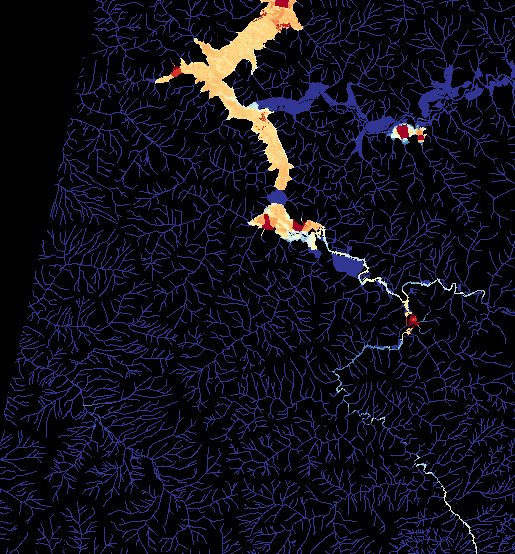

In [27]:
interactive_map